In [1]:
"""This script has following capabilities:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob
import shutil
import re

from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

In [2]:
# # GLOBAL CONTROL FOR THE PLOTS
# plt.rcParams.update({'font.serif':'Arial', 'font.size': 11.0, 
#                      'xtick.labelsize': 10, 'ytick.labelsize': 10,
#                     'legend.fontsize':10,
#                     'figure.dpi': 80.0, 'figure.figsize': [9, 5]})
# # print(plt.rcParams)

In [3]:
def read_file(filename, skiplines):
    with open(filename) as file:
        lines = file.readlines()
        total_lines = len(lines)
#         print('Total lines:', total_lines)

    # Read the data:
    rlines = lines[skiplines:]
    # Extract data from file
    data = np.array([list(map(float, line.strip().split())) for line in rlines])
#     print("Shape of data:", data.shape)
    header = lines[skiplines-1].strip().split()
    dt = data[1][0] - data[0][0]; # Time interval between data
    return header, dt, data

# Definitions:
def bin_averages(bins, array):
    """bins = contains number of lines to average in each bin, dump_bin
       array = contains TE, KE, PE array with each column representing frames"""
    start_idx = 0
    arr_avg = []
    for interval in bins:
        end_idx = start_idx + interval
        subset = array[start_idx:end_idx]
        avg = np.mean(subset, axis=0)
        arr_avg.append(avg)
        start_idx = end_idx
    return np.array(arr_avg)

def Fourier_transform(time_arr, position_arr):
    """
    time_arr = time for time vs pos, position for pos vs velocity
    position_arr = pos for time vs pos, velocity for pos vs velocity
    """          
    time_step = time_arr[1] - time_arr[0]
    frequencies = np.fft.fftfreq(len(time_arr), time_step) # frequencies for each FFT bin.
    power_spectrum = np.abs(np.fft.fft(position_arr))**2   # Compute the power spectrum.

    # Plot the power spectrum vs frequency.
    mask = frequencies >= 0  # only consider the positive frequencies
    freq_new = frequencies[mask]
    power_spectrum = power_spectrum[mask]
      
    peak_threshold = np.max(power_spectrum) * 0.1  # for example, half of the maximum value
    peaks, _ = find_peaks(power_spectrum, height=peak_threshold)
    peak_freq = frequencies[peaks]
    peak_freq_mag = power_spectrum[peaks]    #/np.max(power_spectrum)
    Wavelength = 1/peak_freq
#     print("Difference in pos:", time_step)
#     print("Peak_freq:", peak_freq)
#     print("Peak_freq_mag:", peak_freq_mag)
#     print("Wavelength:", Wavelength)

    return freq_new, power_spectrum, peak_freq, peak_freq_mag, Wavelength

In [4]:
k      = 290
jid    = 598495
Frame  = 37
t      = 111

header,_ , data = read_file(f'./Frequency_variation/k_{k}_jid_{jid}_Frame_{Frame}_t_{t}ps.lmc', 9)

# header,_ , data = read_file('./Frequency_variation/k_243_jid_598009_Frame_37_t_111ps.lmc', 9)
# header,_ , data = read_file('./Frequency_variation/k_243_jid_598009_Frame_0_t_0ps.lmc', 9)
# header,_ , data = read_file('./Frequency_variation/k_8_jid_595197_Frame_37_t_111ps.lmc', 9)
# header,_ , data = read_file('./Frequency_variation/k_290_jid_598495_Frame_37_t_111ps.lmc', 9)

In [5]:
diff = len(header)-data.shape[1]; #print(diff)
data = pd.DataFrame(data, columns =header[diff:])
data = data.sort_values('z')

# Separating Au, CH2, S atoms  
CH2_only = data[data['type'] ==2.0]
S_only = data[data['type'] ==3.0]
Au_only = data[data['type'] ==1.0]
Au_only = Au_only[Au_only['z']<CH2_only['z'].max()] # This will not take the Au atoms which moved to other side

print("No. of atoms:")
print("Au atoms:", len(Au_only))
print("C atoms:", len(CH2_only))
print("S atoms:", len(S_only))

No. of atoms:
Au atoms: 172320
C atoms: 112000
S atoms: 32


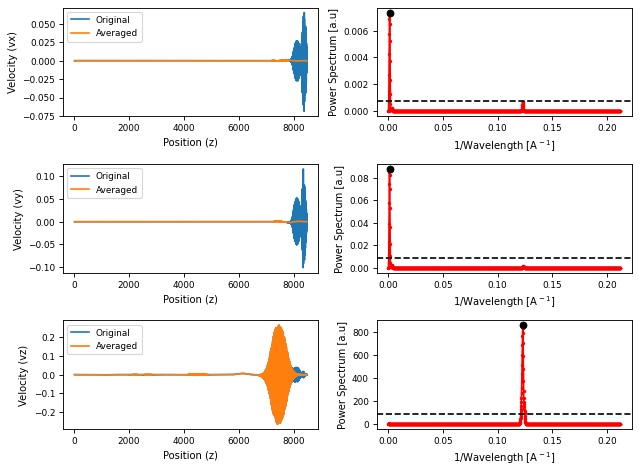

      Rlamdax     Rlamday   Rlamdaz     RMagx     RMagy       RMagz
0  845.593506  845.593506  8.138532  0.007345  0.088176  860.615915


In [10]:
# Fourier analysis of reflected wave:
Au_atoms_per_plane = 48
Au_only = Au_only.reset_index(drop=True)
Au_only_avg = Au_only.groupby(Au_only.index // Au_atoms_per_plane).mean()

Velocity = ['vx', 'vy', 'vz']

pos = str('z')
# vel = str('vy')
Lamda = []
Peak_mag = []
i=0
fig, axs = plt.subplots(len(Velocity),2, figsize=(8,6))
for vel in Velocity:
    
    axs[i, 0].plot(Au_only[pos], Au_only[vel], label='Original')
    axs[i, 0].plot(Au_only_avg[pos], Au_only_avg[vel], label='Averaged')
    axs[i, 0].set_xlabel(f'Position ({pos})')
    axs[i, 0].set_ylabel(f'Velocity ({vel})')
    axs[i, 0].legend()

    # Fourier analysis:
    freq_new, power_spectrum, peakfreq, peakfreqmag, lamda = Fourier_transform(Au_only_avg[pos], Au_only_avg[vel])
    
    Lamda.append(lamda)
    Peak_mag.append(peakfreqmag)
    # Power specturm vs freq
    x = freq_new
    y = power_spectrum #/np.max(power_spectrum)
    axs[i, 1].plot(x, y, '-or', markersize='2')
    axs[i, 1].plot(peakfreq, peakfreqmag, 'ok')
    axs[i, 1].set_xlabel('1/Wavelength [A$^-$$^1$]')
    axs[i, 1].set_ylabel('Power Spectrum [a.u]')
    axs[i, 1].axhline(0.1*np.max(power_spectrum), color='k', ls='--')
    
    i = i+1
    
plt.tight_layout()
plt.savefig(f'./Fourier_transform_analysis/Ref_wave_FT_plots_k_{k}_jid_{jid}_Frame_{Frame}_t_{t}ps.tiff', dpi= 100, bbox_inches = 'tight', facecolor="w")
plt.show()

# Convert the arrays to pandas Series
Lamda_series = [pd.Series(arr) for arr in Lamda]
Peak_mag_series = [pd.Series(arr) for arr in Peak_mag]

# Concatenate the series into a DataFrame
df = pd.concat(Lamda_series + Peak_mag_series, axis=1)

# Provide the column names
df.columns = ['Rlamdax', 'Rlamday', 'Rlamdaz', 'RMagx', 'RMagy', 'RMagz']

# Replace NaN values with empty spaces
df = df.fillna('0')

df.to_csv(f'./Fourier_transform_analysis/Ref_wave_FT_data_k_{k}_jid_{jid}_Frame_{Frame}_t_{t}ps.dat', index=False
         , float_format='%.3f')
print(df)

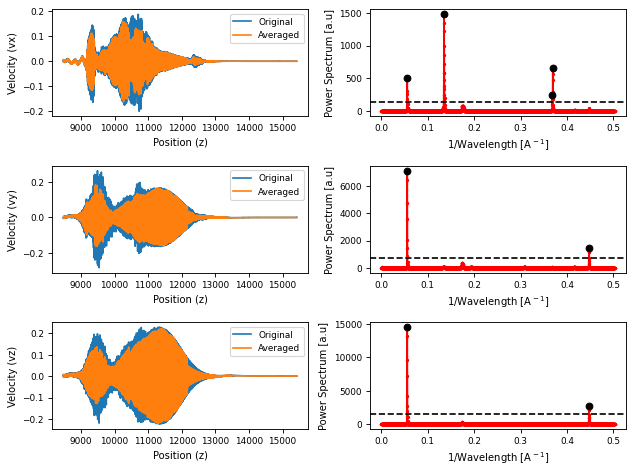

     Tlamdax    Tlamday    Tlamdaz        TMagx        TMagy         TMagz
0  17.891983  17.891983  17.891983   503.291686    7153.3622  14494.176563
1   7.396367   2.234344   2.234344  1475.761485  1478.984235   2644.918445
2   2.714501          0          0   251.790960            0             0
3   2.708164          0          0   662.041240            0             0


In [11]:
plt.rcParams.update({'font.serif':'Arial', 'font.size': 9.0, 
                     'xtick.labelsize': 8, 'ytick.labelsize': 8,
                    'legend.fontsize':8,
                    'figure.dpi': 80.0})

# Fourier analysis of transmitted wave:
CH2_atoms_per_plane = 16
CH2_only = CH2_only.reset_index(drop=True)       # Needed to reset to index to average every 16 lines
CH2_only_avg = CH2_only.groupby(CH2_only.index // CH2_atoms_per_plane).mean()

Velocity = ['vx', 'vy', 'vz']

pos = str('z')
# vel = str('vy')
Lamda = []
Peak_mag = []
i=0
fig, axs = plt.subplots(len(Velocity),2, figsize=(8,6))
for vel in Velocity:
    axs[i,0].plot(CH2_only[pos], CH2_only[vel], label='Original')
    axs[i,0].plot(CH2_only_avg[pos], CH2_only_avg[vel], label='Averaged')
    axs[i,0].set_xlabel(f'Position ({pos})')
    axs[i,0].set_ylabel(f'Velocity ({vel})')
    axs[i,0].legend()

    # Fourier analysis:
    freq_new, power_spectrum, peakfreq, peakfreqmag, lamda = Fourier_transform(CH2_only_avg[pos], CH2_only_avg[vel])
    
    Lamda.append(lamda)
    Peak_mag.append(peakfreqmag)
    # Power specturm vs freq
    x = freq_new
    y = power_spectrum #/np.max(power_spectrum)
    axs[i,1].plot(x, y, '-or', markersize='2')
    axs[i,1].plot(peakfreq, peakfreqmag, 'ok')
    axs[i,1].set_xlabel('1/Wavelength [A$^-$$^1$]')
    axs[i,1].set_ylabel('Power Spectrum [a.u]')
    axs[i,1].axhline(0.1*np.max(power_spectrum), color='k', ls='--')
    
    i = i+1
plt.tight_layout()
plt.savefig(f'./Fourier_transform_analysis/Trans_wave_FT_plots_k_{k}_jid_{jid}_Frame_{Frame}_t_{t}ps.tiff', 
            dpi= 100, bbox_inches = 'tight', facecolor="w")
plt.show()

# Convert the arrays to pandas Series
Lamda_series = [pd.Series(arr) for arr in Lamda]
Peak_mag_series = [pd.Series(arr) for arr in Peak_mag]

# Concatenate the series into a DataFrame
df = pd.concat(Lamda_series + Peak_mag_series, axis=1)

# Provide the column names
df.columns = ['Tlamdax', 'Tlamday', 'Tlamdaz', 'TMagx', 'TMagy', 'TMagz']

# Replace NaN values with empty spaces
df = df.fillna('0')

df.to_csv(f'./Fourier_transform_analysis/Trans_wave_FT_data_k_{k}_jid_{jid}_Frame_{Frame}_t_{t}ps.dat', 
          index=False, float_format='%.3f')
print(df)